In [1]:
import time
import datetime as dt
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

In [2]:
# data directory
DATA_DIR = '../../Input_processed_data'

# IC, 道路情報 csv
IC_CSV = f'{DATA_DIR}/road_master/ic_merged.csv'
IC_NET_CSV = f'{DATA_DIR}/road_master/tateyama_kannetsu_doronet_sub_with_rule.csv'

## functions

In [3]:
def get_oneday(df, date, format='%Y%m%d'):
    '''
    1日分だけdfから取得する
    '''
    cond = df['datetime'].dt.date == dt.datetime.strptime(date, format).date()
    return df.loc[cond].reset_index(drop=True)

In [5]:
def get_ic_order(direction):
    '''
    dfは特定道路についてのデータだと仮定して, その道路上のicの順番を得る
    '''
    # ic_list = [
    #     '長岡南越路スマート', '小千谷', '越後川口', '堀之内', '小出', '大和ＰＡ', '六日町', '塩沢石打', 
    #     '湯沢(関越道)', '水上', '月夜野', '沼田(関越道)', '昭和', '赤城', '渋川伊香保', '駒寄ＰＡ', 
    #     '前橋', '高崎', '高崎ＪＣＴ', '高崎玉村スマート', '藤岡ＪＣＴ', '上里ＳＡ', '本庄児玉', '寄居ＰＡ', 
    #     '花園', '嵐山小川', '東松山', '坂戸西スマート', '鶴ヶ島', '鶴ヶ島ＪＣＴ', '川越', '三芳ＰＡ', 
    #     '所沢', '大泉ＪＣＴ'
    # ]
    ic_list = [
        '長岡南越路スマート', '小千谷', '越後川口', '堀之内', '小出', '大和ＰＡ', '塩沢石打', 
        '湯沢(関越道)', '水上', '月夜野', '沼田(関越道)', '昭和', '赤城', '渋川伊香保', '駒寄ＰＡ', 
        '前橋', '高崎', '高崎ＪＣＴ', '高崎玉村スマート', '藤岡ＪＣＴ', '上里ＳＡ', '本庄児玉', '寄居ＰＡ', 
        '花園', '嵐山小川', '東松山', '坂戸西スマート', '鶴ヶ島', '鶴ヶ島ＪＣＴ', '川越', '三芳ＰＡ', 
        '所沢', '大泉ＪＣＴ'
    ]
    
    if direction == 0:
        order_map = {name: i for i, name in enumerate(ic_list)}
    else:
        order_map = {name: i for i, name in enumerate(reversed(ic_list))}
    
    return order_map

In [6]:
def init_mat(ic_order, sr):
    '''
    ic_orderが並ぶ道路でサンプリングレートsrで取得したデータをヒートマップにする時の行列を初期化する
    '''
    assert sr[-1] == 'h' or sr[-3:] == 'min', 'sampling rate error'
    
    dt_format = '%H:%M'
    if sr[-1] == 'h':
        periods = 24 // int(sr[:-1])
    else:
        periods = 24 * 60 // int(sr[:-3])
    ts = [t.strftime(dt_format) for t in pd.date_range('20220101', periods=periods, freq=sr)]
    
    mat = np.zeros((len(ts), len(ic_order)-1))
    return mat, ts


def get_mat(df, ic_order, direction, sr, num_col, time_col='datetime'):
    '''
    dfのnum_colカラムに入っている値を IC x 時間 の行列に格納する
    道路の方向はdirection, サンプリングレートはsr, 日時情報の入ったカラムはtime_colで指定する
    '''
    mat, ts = init_mat(ic_order, sr)
    ts_map = {t: i for i, t in enumerate(ts)}
    
    for i, row in df.iterrows():
        t = row[time_col].strftime('%H:%M')
        if t not in ts_map:
            continue
        
        start, end, d, n = row[['start_name', 'end_name', 'direction', num_col]]
        if d != direction:
            continue
          
        mat[ts_map[t], ic_order[start]] = n

    return mat, ts

In [29]:
def plot_heatmap(mat, ts, ic_order, sr, xlabel=None, ylabel=None, title=None, ax=None, save_path=None):
    '''
    IC x 時間の行列matをヒートマップで可視化する
    サンプリングした時間はts, ICの順番はic_order, サンプリングレートはsrで指定する
    '''
    ## plot ##
    ax = sns.heatmap(mat, cmap='Greens', linewidth=0.05, cbar=False, ax=ax)

    ## config ##
    assert sr[-1] == 'h' or sr[-3:] == 'min', 'sampling rate error'
    t_step = 60 // int(sr[:-3]) if sr[-3:] == 'min' else 1
        
    xticks = range(len(ic_order))
    # xticklabels = xticks
    xticklabels = ic_order.keys()
    yticks = range(0, len(ts), t_step)
    yticklabels = [ts[i] for i in yticks]
    
    ax.set_xlabel(xlabel, fontsize=18)
    ax.set_ylabel(ylabel, fontsize=18)
    
    ax.set_xticks(ticks=xticks, labels=xticklabels)
    ax.tick_params(axis='x', labelsize=14, labelrotation=75)

    ax.set_yticks(ticks=yticks, labels=yticklabels)
    ax.tick_params(axis='y', labelsize=12, labelrotation=0)
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1)
    return

In [8]:
def zscore(mat):
    mean = mat.mean(axis=0, keepdims=True)
    std = mat.std(axis=0, keepdims=True)
    mat_norm = (mat - mean) / (std + 1e-5)
    return mat_norm

## データ読み込み

In [9]:
df = pd.read_pickle('../datasets/kannetsu_210402-220531.pkl')
df_h = pd.read_pickle('../datasets_1h/kannetsu_210402-220531.pkl')

In [10]:
# rep_map = {
#     # '1800151': '1800146',   # 大和PA -> 六日町
#     '1800146': '1800151',   # 六日町 -> 大和PA
#     '1800072': '1800073',   # 高崎玉村スマート -> 高崎JCT
# }
rep_map = {
    # '1800151': '1800146',   # 大和PA -> 六日町
    '六日町': '大和ＰＡ',   # 六日町 -> 大和PA
    # '高崎玉村スマート': '高崎ＪＣＴ',   # 高崎玉村スマート -> 高崎JCT
}
df.replace(rep_map, inplace=True)
df_h.replace(rep_map, inplace=True)

In [11]:
df_ic = pd.read_csv(IC_CSV, dtype={'ic_code': str})
code2name = dict(zip(df_ic['ic_code'], df_ic['ic_name']))
name2code = {v: k for k, v in code2name.items()}

## main

In [112]:
direction = 0
date = '20220503'
sr = '15min'

df_oneday = get_oneday(df, date)
ic_order = get_ic_order(direction)
mat, ts = get_mat(df_oneday, ic_order, direction, sr, num_col='search_15min')
mat_norm = zscore(mat)

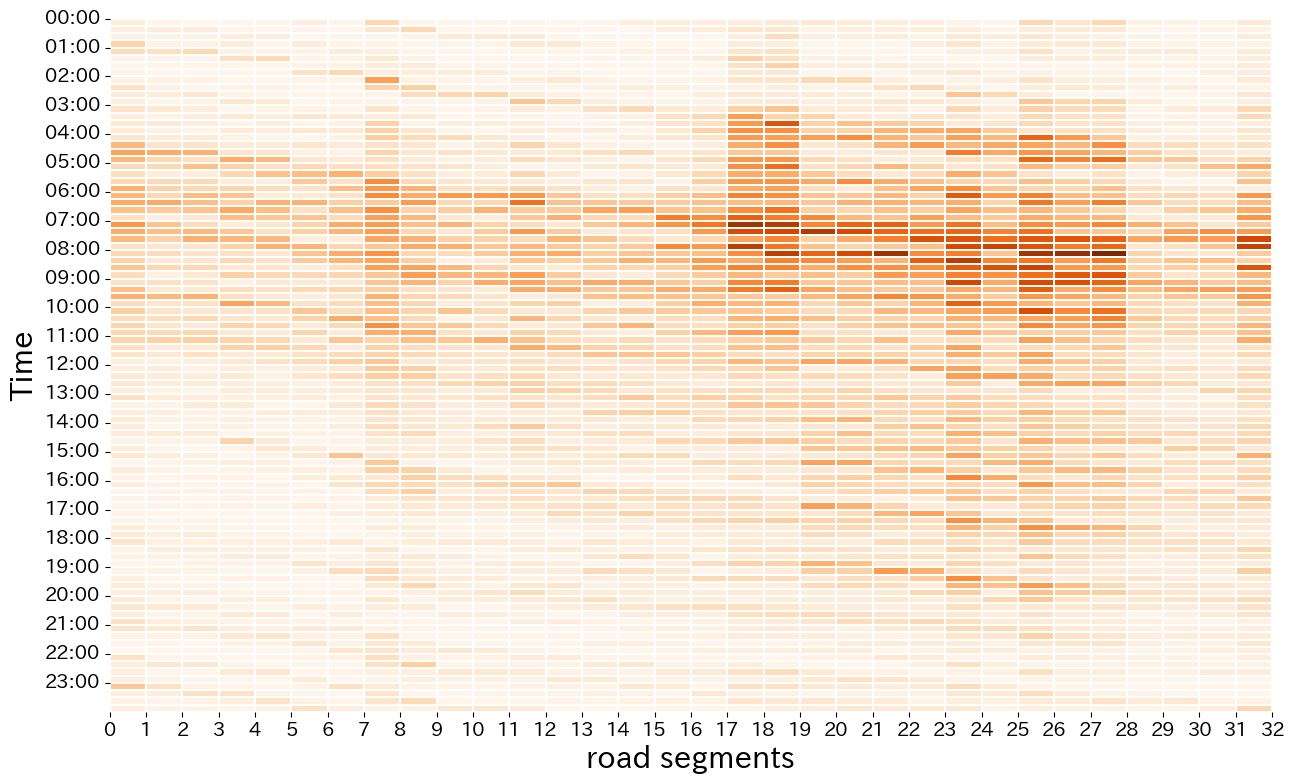

In [113]:
fig, ax = plt.subplots(figsize=(15,9))

plot_heatmap(mat, ts, ic_order, sr, xlabel='road segments', ylabel='Time', ax=ax)

In [12]:
direction = 0
date = '20220503'
sr = '1h'

df_oneday = get_oneday(df_h, date)
ic_order = get_ic_order(direction)
mat, ts = get_mat(df_oneday, ic_order, direction, sr, num_col='search_1h')
mat_norm = zscore(mat)

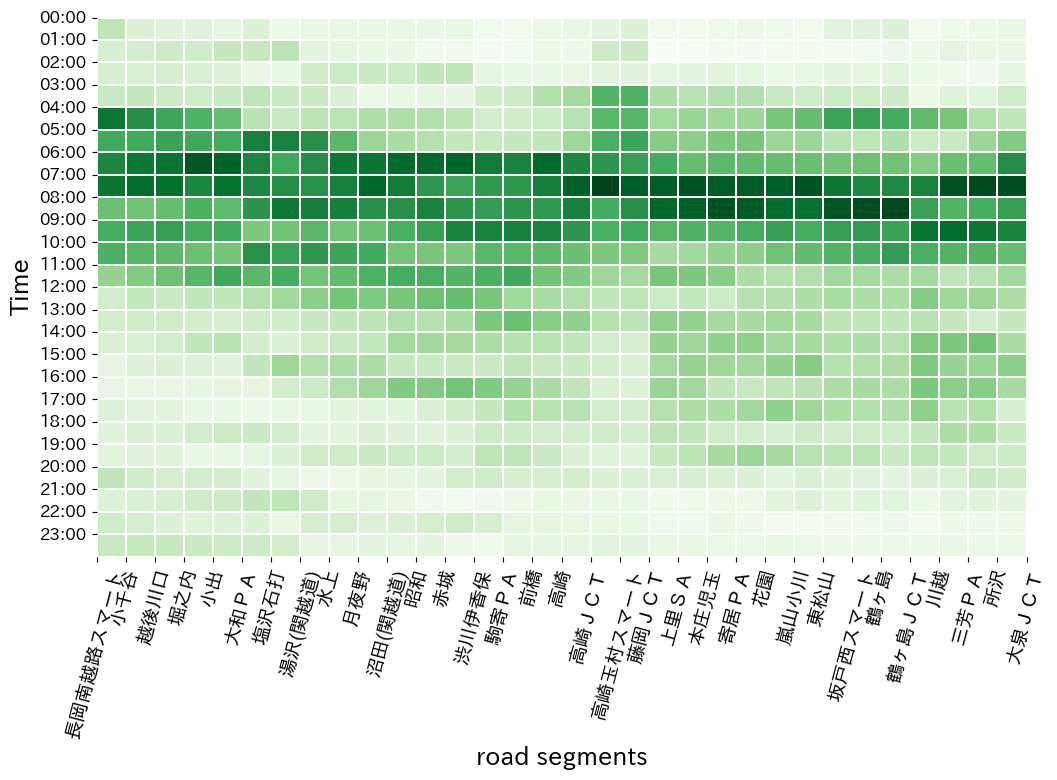

In [31]:
# save_path = '../../figs/ja_search_counts_heatmap.png'
fig, ax = plt.subplots(figsize=(12,7))

plot_heatmap(mat_norm, ts, ic_order, sr, 
             xlabel='road segments', ylabel='Time', ax=ax)

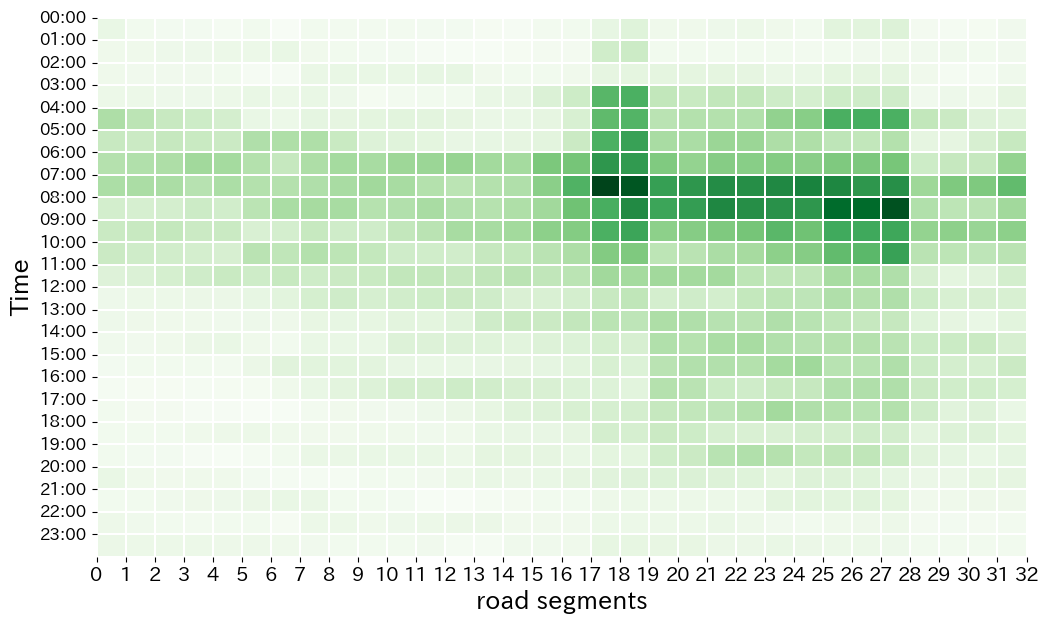

In [151]:
save_path = None
fig, ax = plt.subplots(figsize=(12,7))

plot_heatmap(mat, ts, ic_order, sr, 
             xlabel='road segments', ylabel='Time', ax=ax, save_path=save_path)